In [13]:
import tensorflow as tf
import tensorflow.python.keras
import os
import sys
import numpy as np
import glob
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disables debugging logs for tensorflow on no gpu systems (mostly laptops)


### Importing data
We will use python to handle our filenames,
as well as join the data from high and low temperatures, ignoring the first four entries from either

In [2]:
dataFiles = os.path.join('ML_Data_Phys240_Sp23', '*')
globArray = sorted(glob.glob(dataFiles))
testData = globArray[0:4]
trainSetHiPath = globArray[4]
trainSetLoPath = globArray[5]

hiTrainMatrix = np.loadtxt(trainSetHiPath)
loTrainMatrix = np.loadtxt(trainSetLoPath)

hiTrainMatrix = hiTrainMatrix[:, 4:]  # ignore the first four
loTrainMatrix = loTrainMatrix[:, 4:]  # ignore the first four

hiPlusLo = np.concatenate((hiTrainMatrix, loTrainMatrix))

#### Visualizing training data

Text(0.5, 0.98, 'Low temp')

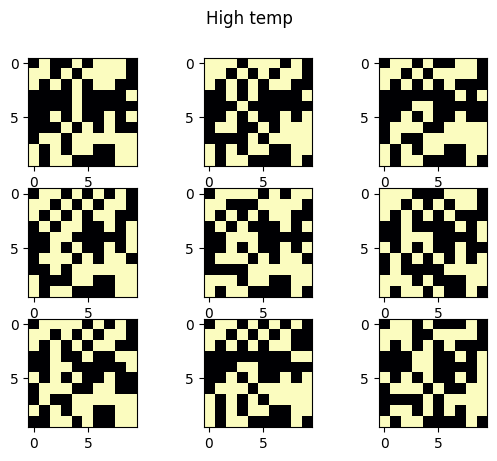

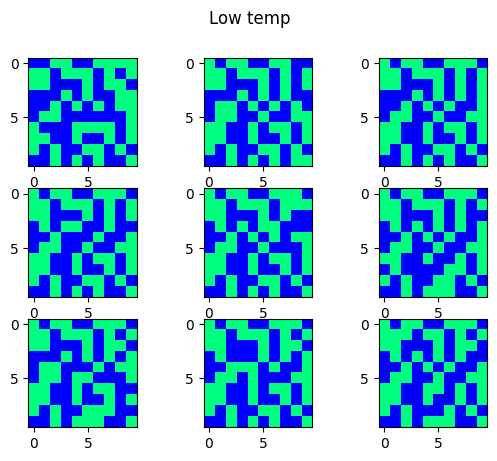

In [3]:
N = 20_000

testImgs = np.reshape(hiPlusLo,
                      (N, 10, 10, 1))  # 20_000 10x10 imgs with 1 color channel
hiImgs = np.reshape(hiTrainMatrix, (N // 2, 10, 10, 1))
loImgs = np.reshape(loTrainMatrix, (N // 2, 10, 10, 1))

# using the variable axs for multiple Axes
fig1, axs1 = plt.subplots(3, 3)
fig2, axs2 = plt.subplots(3, 3)

for i, (ax1, ax2), in enumerate(zip(axs1.flatten(), axs2.flatten())):
    ax1.imshow(hiImgs[i], cmap='magma')
    ax2.imshow(loImgs[i], cmap='winter')

fig1.suptitle('High temp')
fig2.suptitle('Low temp')

#### Train/Test Split + Data Preprocessing
The model will immediately begin to overfit if fed non-randomized data.
Below is a randomization that preserves the labels (i.e., the image is shuffled in unison with its associated label) 

In [4]:
p = np.random.permutation(N)

X = testImgs
X = testImgs[:, 1:-1, 1:-1, :]  # truncates training imgs to 8x8
Y = np.zeros((N, 2))
Y[:N // 2, 0] = 1
Y[N // 2:, 1] = 1

# Shuffle X and Y in unison
X = X[p, :, :, :]
Y = Y[p, :]
X[X == 0] = -1  # replace 0s with -1s

X_train = X[:8 * N // 10, :, :, :]
Y_train = Y[:8 * N // 10, :]
X_test = X[8 * N // 10:, :, :, :]
Y_test = Y[8 * N // 10:, :]

#### Model Creation and Architecture
We use a convolutional neural network

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D


def create_model():
    model = Sequential([
        Conv2D(filters=4, kernel_size=(3, 3), input_shape=(8, 8, 1)),
        Activation('relu'),
        Flatten(),
        Dense(units=8, activation='relu'),
        Dense(units=2, activation='softmax')
    ])

    return model

In [6]:
model = create_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 4)           40        
                                                                 
 activation (Activation)     (None, 6, 6, 4)           0         
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 8)                 1160      
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,218
Trainable params: 1,218
Non-trainable params: 0
_________________________________________________________________


In [7]:
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [8]:
history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=100,
                    batch_size=100)

Epoch 1/100
160/160 [==============================] - 1s 3ms/step - loss: 0.6481 - accuracy: 0.6184 - val_loss: 0.5868 - val_accuracy: 0.6908
Epoch 2/100
160/160 [==============================] - 0s 2ms/step - loss: 0.5332 - accuracy: 0.7316 - val_loss: 0.4943 - val_accuracy: 0.7628
Epoch 3/100
160/160 [==============================] - 0s 3ms/step - loss: 0.4723 - accuracy: 0.7714 - val_loss: 0.4556 - val_accuracy: 0.7935
Epoch 4/100
160/160 [==============================] - 0s 3ms/step - loss: 0.4433 - accuracy: 0.7931 - val_loss: 0.4395 - val_accuracy: 0.8015
Epoch 5/100
160/160 [==============================] - 0s 3ms/step - loss: 0.4268 - accuracy: 0.8038 - val_loss: 0.4301 - val_accuracy: 0.8050
Epoch 6/100
160/160 [==============================] - 0s 3ms/step - loss: 0.4137 - accuracy: 0.8114 - val_loss: 0.4226 - val_accuracy: 0.8077
Epoch 7/100
160/160 [==============================] - 1s 3ms/step - loss: 0.4028 - accuracy: 0.8186 - val_loss: 0.4163 - val_accuracy: 0.8075

Epoch 58/100
160/160 [==============================] - 1s 3ms/step - loss: 0.2667 - accuracy: 0.8868 - val_loss: 0.3415 - val_accuracy: 0.8575
Epoch 59/100
160/160 [==============================] - 1s 3ms/step - loss: 0.2663 - accuracy: 0.8887 - val_loss: 0.3426 - val_accuracy: 0.8602
Epoch 60/100
160/160 [==============================] - 1s 3ms/step - loss: 0.2650 - accuracy: 0.8909 - val_loss: 0.3419 - val_accuracy: 0.8610
Epoch 61/100
160/160 [==============================] - 1s 3ms/step - loss: 0.2646 - accuracy: 0.8894 - val_loss: 0.3400 - val_accuracy: 0.8593
Epoch 62/100
160/160 [==============================] - 1s 3ms/step - loss: 0.2643 - accuracy: 0.8880 - val_loss: 0.3411 - val_accuracy: 0.8590
Epoch 63/100
160/160 [==============================] - 1s 3ms/step - loss: 0.2631 - accuracy: 0.8896 - val_loss: 0.3402 - val_accuracy: 0.8577
Epoch 64/100
160/160 [==============================] - 1s 3ms/step - loss: 0.2619 - accuracy: 0.8908 - val_loss: 0.3421 - val_accuracy:

#### Filter visualization
We show a visual representation of the filters post-training

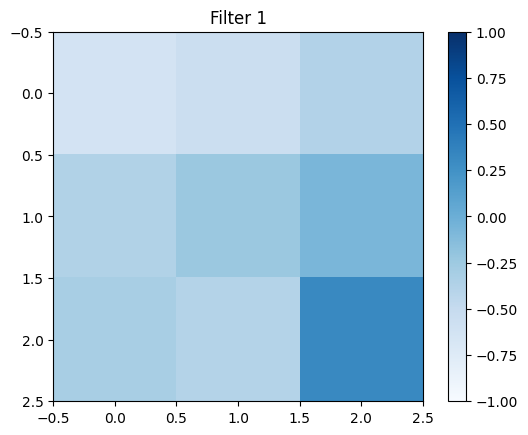

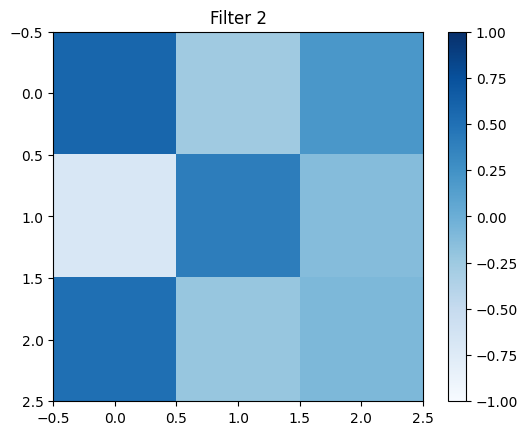

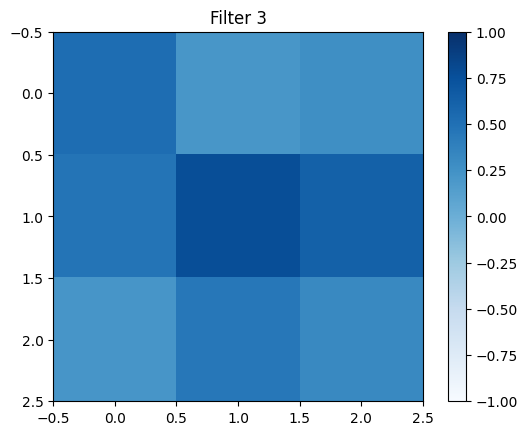

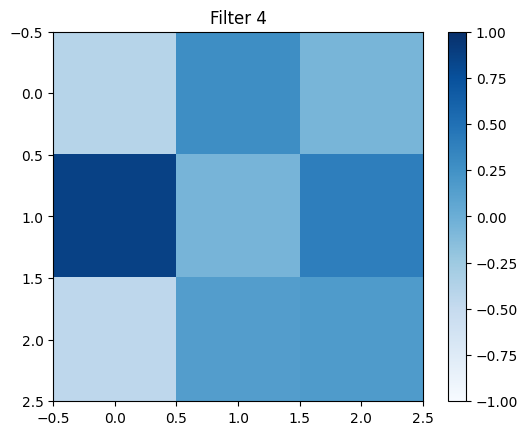

In [9]:
np.shape(model.get_weights()[0])
weights = model.get_weights()[0][:, :, 0, :]

# look at the filters after training
for i in range(4):
    plt.figure()
    plt.title(f'Filter {i+1}')
    plt.imshow(weights[:, :, i],
               interpolation='none',
               cmap='Blues',
               vmin=-1,
               vmax=1)
    plt.colorbar()

#### Model performance during training
Below is a plot detailing the model's performance with consideration to accuracy and loss metrics for both the training data and validation data

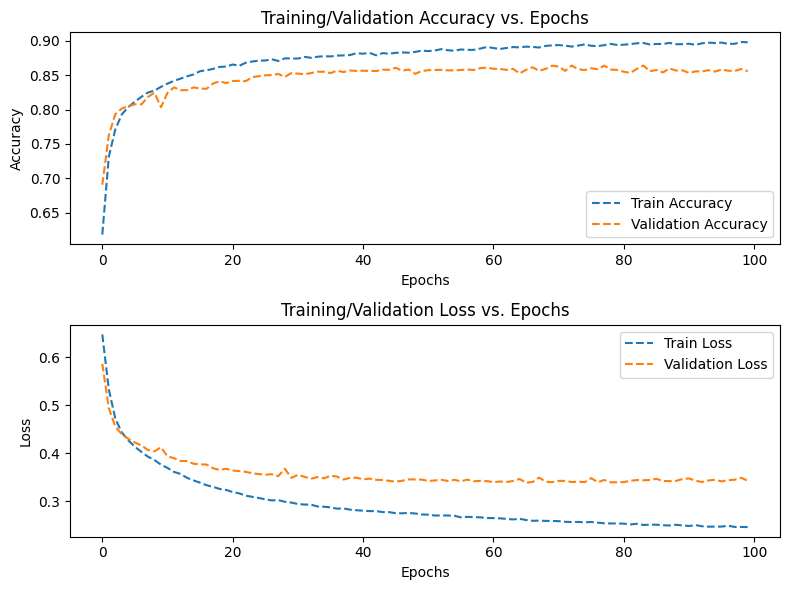

In [10]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

ax[0].set_title('Training/Validation Accuracy vs. Epochs')
ax[0].plot(train_accuracy, '--', label='Train Accuracy')
ax[0].plot(val_accuracy, '--', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, '--', label='Train Loss')
ax[1].plot(val_loss, '--', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

#### Using the model to predict
Below is a user-defined function that allows for input of a data file for the model to run on, producing a prediction of the data on whether the data from a given experiment is hot or cold dominant

In [11]:
def test_routine(expPath):
    exp = np.loadtxt(expPath)
    exp = np.reshape(exp, (np.shape(exp)[0], 12, 12, 1))
    #     exp = exp[:, 1:-1, 1:-1, :] # cut out bg - now 10,10
    exp = exp[:, 2:-2, 2:-2, :]  # cut out bg - now 8, 8

    fig, axs = plt.subplots(3, 5)
    fig.suptitle(expPath.split('/')[1])  # or plt.suptitle('Main title')
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(exp[i], cmap='Greys')

    y_pred = model.predict(exp, verbose=0)
    np.sum(y_pred)

    probs = y_pred[:, 0] - y_pred[:, 1]
    hotInds = np.where(probs > 0)
    percent = np.shape(hotInds)[-1] / np.shape(exp)[0]
    print(f'Model predicts {percent*100:.2f}% of the data is hot')
    if percent * 100 > 50.0:
        dist = 'hot'
    else:
        dist = 'cold'
    print(f'Therefore data is overall {dist}')


TestSet_1
Model predicts 46.62% of the data is hot
Therefore data is overall cold

TestSet_2
Model predicts 50.72% of the data is hot
Therefore data is overall hot

TestSet_3
Model predicts 62.57% of the data is hot
Therefore data is overall hot

TestSet_4
Model predicts 64.14% of the data is hot
Therefore data is overall hot


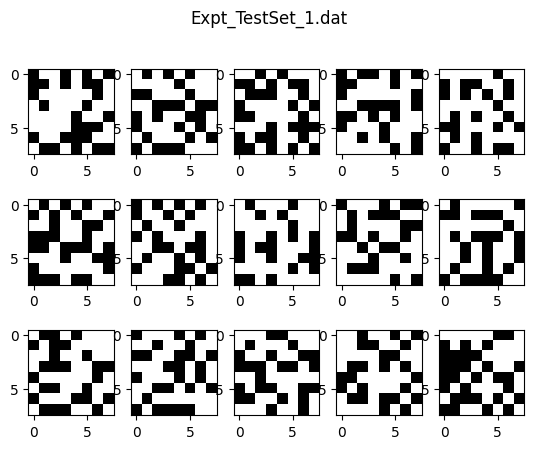

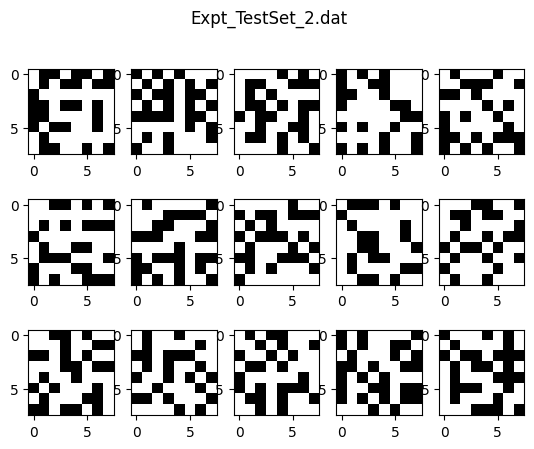

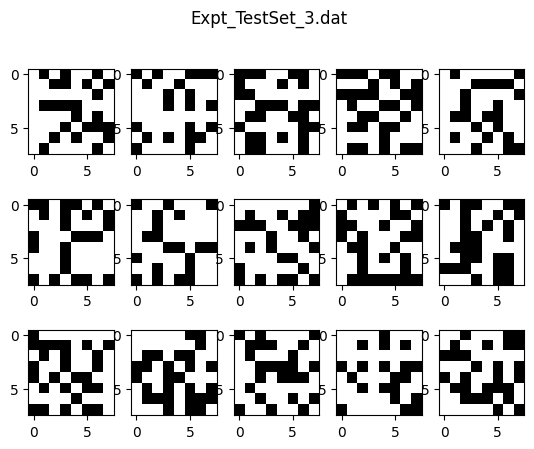

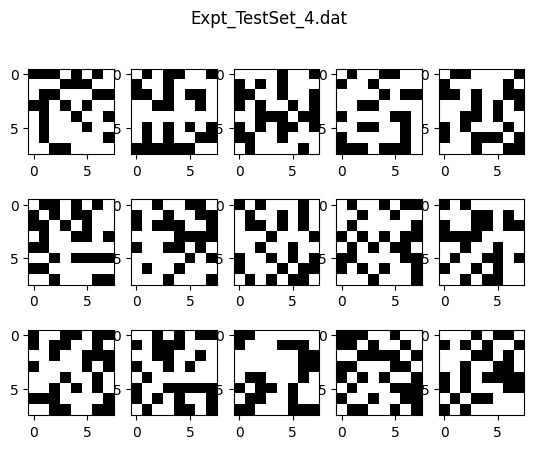

In [12]:
for i, d in enumerate(testData):

    # access the relative path -- there are functions for this but oh well
    name = d.split('/')[1]

    print(f'\n{name[5:-4]}')

    test_routine(testData[i])

# Conclusion
In conclusion, we found that the convolutional neural network model was able to differentiate between hot and cold temperature pictures. From our understanding of the filters, we noticed a filter that resembles a checkerboard pattern, which is characteristic of the Hubbard model at lower temperatures. Additionally, we found that the model performed reasonably on the test data set of experiments 1-4, matching its categorization of the datasets as either hot or cold with the literature. Overall, the model proved a tentatively interesting approach of using image classification to understand the underlying physics of quantum gas systems like the ones presented in this dataset.
